# Introduction

In this project, we will use [this Kaggle dataset](https://www.kaggle.com/c/nlp-getting-started/overview) to train a RNN to identify tweets that indicate a disaster is occurring -- i.e., binary classification (`1` indicates a tweet is discussing a disaster). The training dataset includes labels that were added by hand by the company Figure Eight, who originated the dataset.

As noted in the Kaggle competition, a user's intent may be metaphorical (or sarcastic, ironic, etc.), which is not easily understood by a machine:

> The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

Hopefully, the RNN built below can overcome this obstacle somewhat.

In [1]:
# # Some nonsense to connect to kaggle and download the dataset.
# # Reference: https://www.geeksforgeeks.org/how-to-import-kaggle-datasets-directly-into-google-colab/
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! rm kaggle.json

In [3]:
# ! kaggle competitions download -c nlp-getting-started

In [5]:
# ! unzip nlp-getting-started.zip -d data

In [144]:
import re
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
import nltk
from gensim.models import Word2Vec

In [27]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Exploratory Data Analysis and Data Cleaning

There are 10,876 tweets in the dataset, being 7613 in the training data and 3263 in the test data, for a test/train split of 30/70.

However, we do not have access to the labels for the test data until after submission, so that will not be used for validation during training.

In [7]:
data_dir = Path('data')
train_data_fp = data_dir / 'train.csv'
test_data_fp = data_dir / 'test.csv'

In [8]:
train_raw = pd.read_csv(train_data_fp)
test_raw = pd.read_csv(test_data_fp)

In [9]:
train_raw.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Both categories are well represented in the training data, with 43% being in the disaster category (`1`).

Total number of data points in training data: 7613
Number of '1' labels: 3271 (43.0%)
Number of '0' labels: 4342 (57.0%)


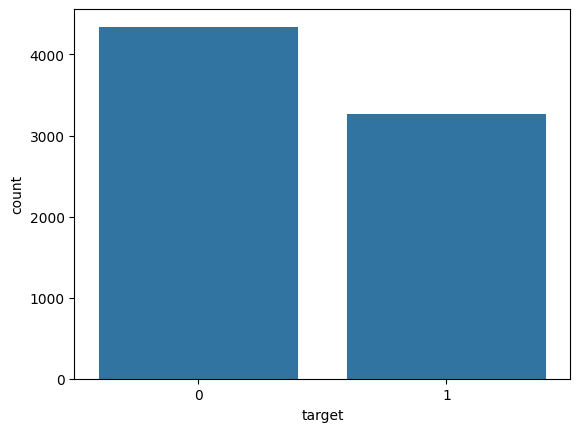

In [10]:
n_train = len(train_raw)
ones = train_raw[train_raw['target'] == 1]
zeros = train_raw[train_raw['target'] == 0]
print(f"Total number of data points in training data: {n_train}")
print(f"Number of '1' labels: {len(ones)} ({len(ones) / n_train * 100:.1f}%)")
print(f"Number of '0' labels: {len(zeros)} ({len(zeros) / n_train * 100:.1f}%)")
sns.countplot(x='target', data=train_raw)
plt.show()

In [11]:
n_test = len(test_raw)
print(f"Total number of data points in test data: {n_test}")
test_split = n_test / (n_train + n_test)
print(f"Test / train split: {(test_split * 100):.1f} / {(1 - test_split) * 100:.1f}")

Total number of data points in test data: 3263
Test / train split: 30.0 / 70.0


Only some entries include `'keyword'` or `'location'` data.

In [12]:
example = train_raw[train_raw['id'] == 10029]
print('Full text of tweet:\n')
print(example['text'].values[0])
example

Full text of tweet:

This is my jam: Riser by Dierks Bentley @1061TheTwister ? #iHeartRadio #NowPlaying http://t.co/zQoScQD64h http://t.co/yLvVF139BB


,id,keyword,location,text,target
6993,10029,twister,"Riverdale, GA",This is my jam: Riser by Dierks Bentley @1061T...,0


We'll extract a few features from the text of each tweet and show the correlation matrix with `target`:

* `has_twit_url` -> Whether the text contains `'t.co/'` (Twitter's URL shortener)
* `word_ct` -> Count of strings separated by whitespaces (roughly the word count, although agnostic to the content of each separated string)
  * Excludes 'words' that contain `'t.co/'` (i..e, strip out twitter URLs)
* `char_ct` -> Character count
  * Also excludes characters within 'words' that contain `'t.co/'` (i..e, strip out twitter URLs)
* `hash_ct` -> Count of hashtags (but if more than 6, flattened to 6)
* `at_user_ct` -> Count of `'@<any_user>'`


We find some modest correlations with `target`.  (And `word_ct` and `char_ct` are strongly correlated, as we would expect.)

In [13]:
# Only matches @some_user at start of string or following a whitespace character.
at_user_rgx = re.compile(r"((?<=\A)|(?<=\s))@[a-zA-Z0-9_]+")

def eda_features(df, text_field='text', tco_url_substr='t.co/', at_user_token: str = None):
    """
    Create a copy to the dataframe and add EDA features.
    :param df:
    :param text_field: Column to look in for text.
    :param tco_url_substr: The substring to look for to count `t.co/` URLs.
    :param at_user_token: If not specified, will use the regex pattern to find
     and count `'@<any_user>'`. If specified, will look for this exact string
     instead. (Use this to count it after preprocessing is complete.)
    """
    eda = df.copy()
    eda['has_twit_url'] = eda[text_field].apply(lambda x: x.count(tco_url_substr) > 0)
    # Ugly chain of calls, but just stripping out 'words' that contain `t.co/` URL.
    eda['text_excl_twit_url'] = eda[text_field].apply(
        lambda x: ' '.join([wd for wd in x.split() if not tco_url_substr in wd]))
    eda['word_ct'] = eda['text_excl_twit_url'].apply(lambda x: len(x.split()))
    eda['char_ct'] = eda['text_excl_twit_url'].apply(lambda x: len(x))

    # 'hash_ct' above 6 gets flattened to 6.
    eda['hash_ct'] = eda[text_field].apply(lambda x: x.count('#')).apply(lambda x: 6 if x > 6 else x)
    if at_user_token is not None:
        eda['at_user_ct'] = eda[text_field].apply(lambda x: x.count(at_user_token))
    else:
        eda['at_user_ct'] = eda[text_field].apply(lambda x: len(at_user_rgx.findall(x)))
    return eda

def show_corr_heatmap(eda_df, title=None):
    """Show the correlation heatmap of relevant features."""
    corr = eda_df[['target', 'word_ct', 'char_ct', 'hash_ct', 'at_user_ct', 'has_twit_url']].corr()
    ax = sns.heatmap(corr, annot=True, cmap='mako')
    if title is None:
        title = 'Correlation Matrix'
    ax.set(title=title)
    plt.show()

def word_char_ct_plots(eda_df):
    """Show summary stats and hist plots for word count and character count."""
    print(f"Mean word count: {eda_df['word_ct'].mean():.1f}")
    print(f"Median word count: {eda_df['word_ct'].median():.1f}")
    print(f"Mean character count: {eda_df['char_ct'].mean():.1f}")
    print(f"Median character count: {eda_df['char_ct'].median():.1f}")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.histplot(eda_df['word_ct'], bins=eda_df['word_ct'].max(), stat='density', ax=axes[0])
    axes[0].set(title='Word Count in Tweets')

    sns.histplot(eda_df['char_ct'], stat='density', ax=axes[1])
    axes[1].set(title='Character Count in Tweets')
    plt.show()


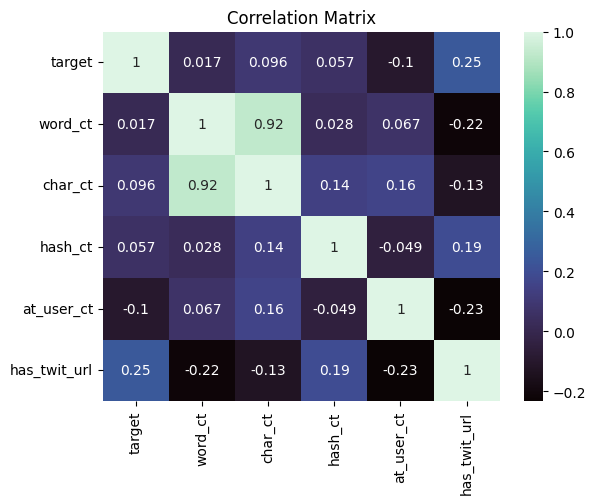

In [14]:
eda_train = eda_features(train_raw)
show_corr_heatmap(eda_train)

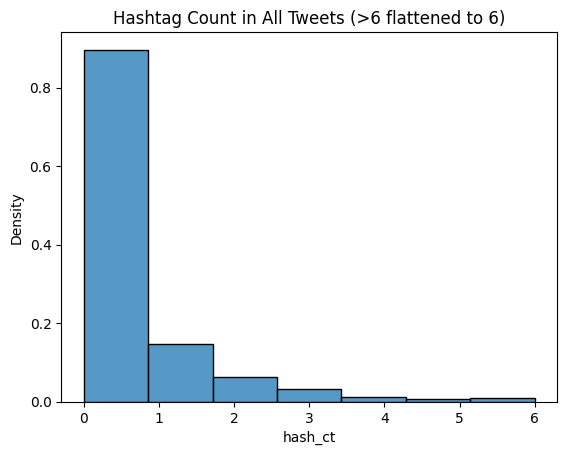

In [15]:
ax = sns.histplot(eda_train['hash_ct'], bins=7, stat='density')
ax.set(title='Hashtag Count in All Tweets (>6 flattened to 6)')
plt.show()

We can see the law of large numbers at work in the word count and character count, with a couple interesting snags in the character count.

The max length of tweets was originally 140 but was eventually increased to 280. There is a small spike around 140 characters, which probably indicates that much of the dataset came from before that increase.

Moreover, there is a substantial spike at 113 characters, which is discussed below.

Mean word count: 14.3
Median word count: 14.0
Mean character count: 86.6
Median character count: 88.0


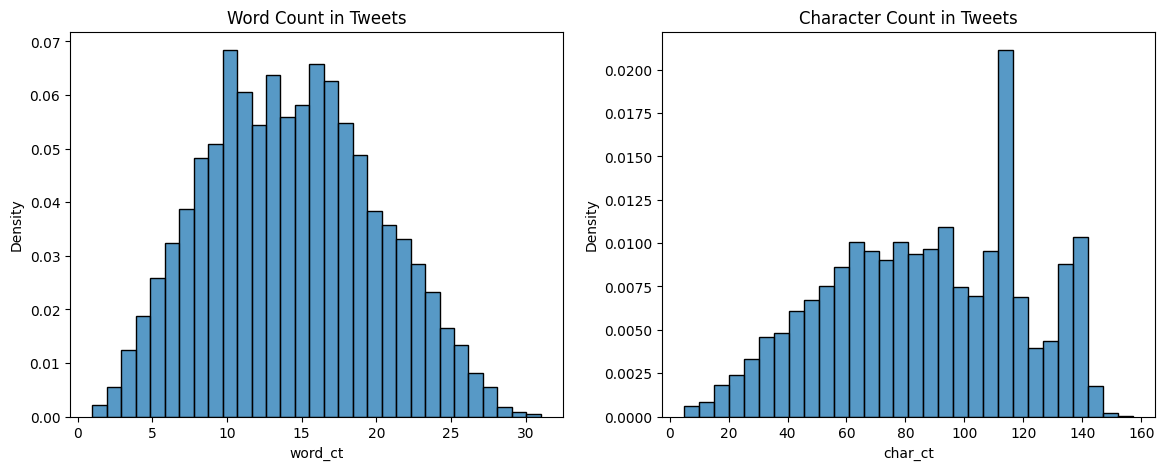

In [16]:
word_char_ct_plots(eda_train)

As for the spike at 113 characters, this appears to be caused by elliding tweets to linked news articles, presumably automatically shared by users or news outlets.

In [17]:
mode_char_ct = eda_train['char_ct'].mode()[0]  # 113 characters.
texts_with_mode_char_lens = eda_train[eda_train['char_ct'] == mode_char_ct]['text']
for text in texts_with_mode_char_lens[:5]:
    print(text)

Carolina accident: Motorcyclist Dies in I-540 Crash With Car That Crossed Median: A motorcycle rider traveling... http://t.co/p18lzRlmy6
Experts in France begin examining airplane debris found on Reunion Island: French air accident experts o... http://t.co/YVVPznZmXg #news
Strict liability in the context of an airplane accident: Pilot error is a common component of most aviation cr... http://t.co/6CZ3bOhRd4
Experts in France begin examining airplane debris found on Reunion Island: French air accident experts on Wedn... http://t.co/bKpFpOGySI
Experts in France begin examining airplane debris found on Reunion Island: French air accident experts on... http://t.co/TagZbcXFj0 #MLB


This also shows there are duplicates and "near-duplicates" in the dataset that should presumably be scrubbed. This is somewhat complicated by hashtags appearing to the right of the `'t.co/'` URL.

However, I suspect that the inclusion of a `'t.co/'` URL will have some predictive power in this classification problem, so we'll use a regular expression to swap out all `'t.co/'` URLs for a URL token (`'TCO_URL'`); and use another regular expression to cut out the final word before ellision if it maybe gets cut off (i.e., if it 'touches' the ellipses) -- in other words, we'll convert this:

> `'Experts in France begin examining airplane debris found on Reunion Island: French air accident experts on... http://t.co/TagZbcXFj0 #MLB'`

...to this:

> `'Experts in France begin examining airplane debris found on Reunion Island: French air accident experts TCO_URL #MLB'`

Similarly, `'@jack'` (or @ any user) will be replaced with an at_user token (`'AT_SOME_USER'`).

In [18]:
TCO_SUB = 'TCO_URL'
# It's kinda bad practice to use f-strings for regex, so don't tell anybody.
# Regex is hard to read, but I'll include an example with these below.
tco_ellide_rgx = re.compile(rf"\A(?P<body>.+?)(?P<tco_ellide>(?P<partial_word>\w+)?\.\.\. {TCO_SUB})(?P<final_hashtags>( #\S+)*)\Z")
tco_rgx = re.compile(r"http:\/\/t\.co\/\S{10}")

def scrub_tco_urls(s, replace_with=TCO_SUB):
    return tco_rgx.sub(replace_with, s)

def scrub_whitespace(s):
    return re.sub(r"\s+", " ", s)

def scrub_ellisions(s, tco_sub=TCO_SUB):
    mo = tco_ellide_rgx.search(s)
    if not mo:
        return s
    out = mo.group('body')
    out += tco_sub
    if mo.group('final_hashtags'):
        out += ' ' + mo.group('final_hashtags')
    return out

AT_USER_SUB = 'AT_SOME_USER'
# Only matches @some_user at start of string or following a whitespace character.
at_user_rgx = re.compile(r"((?<=\A)|(?<=\s))@[a-zA-Z0-9_]+")

def scrub_at_users(s, replace_with=AT_USER_SUB):
    return at_user_rgx.sub(replace_with, s)

def scrub_text(s):
    """Perform all of the scrubbing functions on the string."""
    s = scrub_tco_urls(s)
    s = scrub_ellisions(s)
    s = scrub_at_users(s)
    s = scrub_whitespace(s)
    return s

In [19]:
example = "Experts in France begin examining airplane debris found on Reunion Island: French air accident experts on... http://t.co/TagZbcXFj0 #MLB"
example_subbed_tco = scrub_tco_urls(example)
example_scrubbed_ellision = scrub_ellisions(example_subbed_tco)

print("Original:")
print("    ", example, end='\n\n')
print(f"With subbed t.co URL:")
print("    ", example_subbed_tco, end='\n\n')
print(f"Scrubbed out ellision:")
print("    ", example_scrubbed_ellision, end='\n\n')

print("\nAnd here's a demonstration of the regex groups:")
mo = tco_ellide_rgx.search(example_subbed_tco)
print(f" -- body: <{mo.group('body')}>")
print(f" -- tco_ellide: <{mo.group('tco_ellide')}>")
print(f" -- partial_word: <{mo.group('partial_word')}>")
print(f" -- final_hashtags: <{mo.group('final_hashtags')}>")

Original:
     Experts in France begin examining airplane debris found on Reunion Island: French air accident experts on... http://t.co/TagZbcXFj0 #MLB

With subbed t.co URL:
     Experts in France begin examining airplane debris found on Reunion Island: French air accident experts on... TCO_URL #MLB

Scrubbed out ellision:
     Experts in France begin examining airplane debris found on Reunion Island: French air accident experts TCO_URL  #MLB


And here's a demonstration of the regex groups:
 -- body: <Experts in France begin examining airplane debris found on Reunion Island: French air accident experts >
 -- tco_ellide: <on... TCO_URL>
 -- partial_word: <on>
 -- final_hashtags: < #MLB>


It would probably be *__ideal__* to consider the following scrubbed tweets as duplicates:

* `'Experts in France begin examining airplane debris found on Reunion Island: French air accident experts on TCO_URL'`
* `'Experts in France begin examining airplane debris found on Reunion Island: French air accident experts TCO_URL'`
* `'Experts in France begin examining airplane debris found on Reunion Island: French air accident experts TCO_URL #MLB'`

However, an algorithm for that sounds like a LeetCode challenge that I don't want to bother with for this weekly assignment, so we'll leave those near-duplicates in the dataset, and leave that optimization for future work.

In [20]:
train = train_raw.copy()
test = test_raw.copy()

train['text_scrubbed'] = train['text'].apply(scrub_text)
test['text_scrubbed'] = test['text'].apply(scrub_text)
# And in case we want to train a model without the t.co URLs in the text...
train['text_scrubed_no_tco'] = train['text_scrubbed'].apply(lambda x: scrub_tco_urls(x, ''))
test['text_scrubed_no_tco'] = test['text_scrubbed'].apply(lambda x: scrub_tco_urls(x, ''))

In [21]:
print(f"Number of identified duplicates in training data: {sum(train.duplicated(['text_scrubbed']).astype(int))}")
print(f"Number of identified duplicates in test data: {sum(test.duplicated(['text_scrubbed']).astype(int))}")

Number of identified duplicates in training data: 635
Number of identified duplicates in test data: 145


In [22]:
train = train.drop_duplicates(subset=['text_scrubbed'], keep='first')

Let's take a second look at our plots, etc. after scrubbing. Note that character counts are slightly skewed by the strings we arbitrarily chose as tokens for `'t.co/'` URLS (now `'TCO_URL'`) and `'@<any_user>'` (now `'AT_SOME_USER'`), but the spikes in the histogram around ~120 and 140 characters are now much less pronounced. (The spikes aren't *intrinsically* better or worse, but they might indicate some clipped data or other issues that could impact the model's ability to learn.)

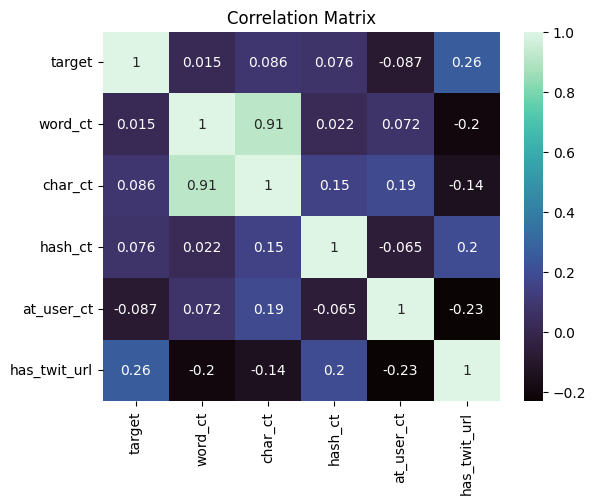

Mean word count: 14.3
Median word count: 14.0
Mean character count: 87.4
Median character count: 89.0


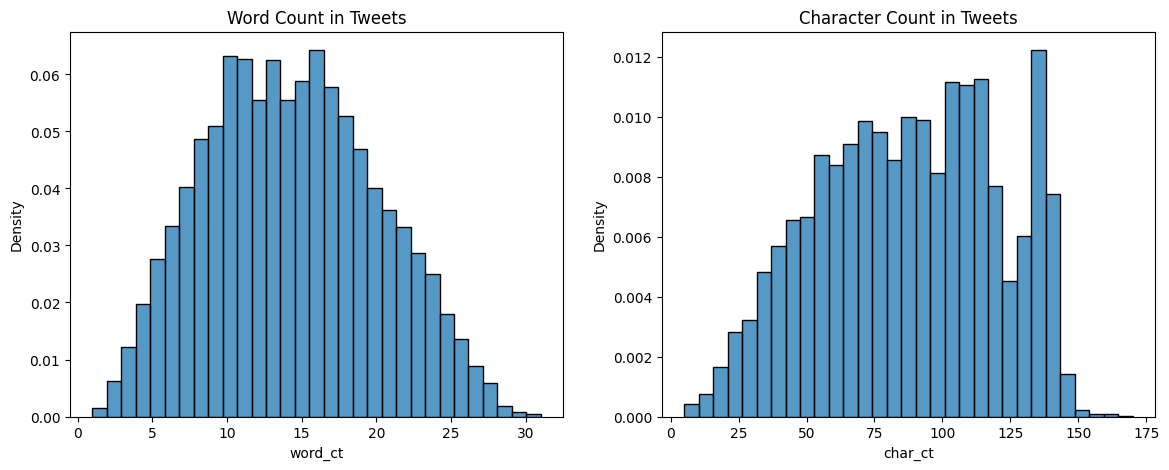

In [23]:
train_eda_post_scrub = eda_features(
    train,
    text_field='text_scrubbed',
    tco_url_substr=TCO_SUB,
    at_user_token=AT_USER_SUB
)
show_corr_heatmap(train_eda_post_scrub)
word_char_ct_plots(train_eda_post_scrub)

For future optimizations, we might look at the remaining noise in the character count histogram that occurs in character counts between 100 and 140 and see if further preprocessing is warranted.

# Model Architecture and Training

## Word2Vec

(I referenced this guide from [Geeks For Geeks](https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/) on __Word2Vec__.)

Some other NLP techniques like Term Frequency-Inverse Document Frequence (TF-IDF) or a simpler count vectorizer extract the words from documents and create a document-term matrix (DTM) -- and that DTM is then fed into a machine learning model.

On the other hand, the RNN built below will take as input a vector generated by __Word2Vec__, which determines semantic 'similarity' Very loosely speaking, that similarity is calculated by examining which words occur in similar contexts to one another. Word2Vec places semantically similar words close together in the vector space, wherein words interact 'algebraically'. Quoting the article referenced above:

> Word2Vec generates vector representations that have intriguing algebraic characteristics. Vector arithmetic, for instance, can be used to record word relationships. One well-known example is that the vector representation of “queen” could resemble the vector representation of “king” less “man” plus “woman.”

## RNN

For the RNN, we'll use a Gated Recurrent Unit (GRU) to avoid a vanishing gradient. We'll use a ReLU activation function for the hidden layer. We'll use a dropout layer to avoid overfitting, and use a single dense layer with a sigmoid activation for the binary classification output.

We'll use __Adam__ as the optimizer to minimize __binary cross-entropy__ and measure __accuracy__ and __F1__ scores (the Kaggle competition judges by F1 score, so we include it here).

Stemming (reducing words to their root form, such as 'copying' to 'copy') is a common preprocessing technique when working with natural language corpus data. [This response](https://stats.stackexchange.com/a/523076) to a question on StackExchange recommends against stemming when using embedding, so we'll forego it here. (Future work might include comparing results with and without stemming.)

In [71]:
# Tokenize.
train['text_tokenized'] = train['text_scrubbed'].apply(lambda x: nltk.word_tokenize(x))
# ChatGPT recommended a vector size of ~100 to 150 for a smaller corpus, so we'll try 100.
VEC_SIZE = 100
w2v = Word2Vec(train['text_tokenized'], vector_size=VEC_SIZE, min_count=2)

In [72]:
vocab = w2v.wv.key_to_index
print("Number of words in vocab:", len(vocab))

Number of words in vocab: 7485


In [108]:
def tokens_to_sequence(tokens, vocabulary):
    """Extract indexes from `vocab` dict. Drop out-of-vocabulary (OOV) words."""
    # (Google AI helped troubleshoot this line.)
    return [vocab.get(token, None) for token in tokens if vocab.get(token, None) is not None]

In [109]:
token_counts = train['text_tokenized'].apply(len)
max_len = token_counts.max()
sequences_unpadded = train['text_tokenized'].apply(lambda tokens: tokens_to_sequence(tokens, vocab))
# Pad to same length.
sequences = pad_sequences(sequences_unpadded, maxlen=max_len)

In [110]:
test['text_tokenized'] = test['text_scrubbed'].apply(lambda x: nltk.word_tokenize(x))
sequences_unpadded_test = test['text_tokenized'].apply(lambda tokens: tokens_to_sequence(tokens, vocab))
sequences_test = pad_sequences(sequences_unpadded_test, maxlen=max_len)

In [129]:
def gen_model(gru_units=64, gru_activation='relu', learn_rate=0.001, loss='binary_crossentropy'):
    layers = [
        Embedding(
            input_dim=len(vocab),
            output_dim=VEC_SIZE,
            weights=[w2v.wv.vectors],
            trainable=False
        ),
        GRU(gru_units, activation=gru_activation),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification.
    ]
    model = Sequential(layers)
    adam_opt = Adam(learning_rate=0.001)
    model.compile(optimizer=adam_opt, loss=loss, metrics=['accuracy', 'F1Score'])
    return model

In [102]:
model1 = gen_model()
model1.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ ?                           │         748,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_10 (GRU)                         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 748,500 (2.86 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 748,500 (2.86 MB)

In a previous project, I had a model that overfit, and I had to retrain the model. This time, I asked ChatGPT if it made sense to save a copy of the model after each epoch, and it recommended `ModelCheckpoint`.

In [134]:
def get_checkpoint_callback(model_num: int):
    return ModelCheckpoint(
        filepath = f"models/{model_num}/" + "ep{epoch:02d}.keras",
        monitor = 'val_accuracy',
        save_best_only = False,
        verbose=0,
        save_freq='epoch',  # Save every epoch.
    )

In [104]:
checkpoint_callback = get_checkpoint_callback(model_num=1)
res1 = model1.fit(
    x=sequences,
    y=train['target'],
    epochs=20,
    callbacks=[checkpoint_callback],
    validation_split=0.2,
)

Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - F1Score: 0.5815 - accuracy: 0.5861 - loss: 0.6683 - val_F1Score: 0.6047 - val_accuracy: 0.6433 - val_loss: 0.6283
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - F1Score: 0.5744 - accuracy: 0.6306 - loss: 0.6346 - val_F1Score: 0.6047 - val_accuracy: 0.6683 - val_loss: 0.6207
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - F1Score: 0.5731 - accuracy: 0.6432 - loss: 0.6351 - val_F1Score: 0.6047 - val_accuracy: 0.6819 - val_loss: 0.6004
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - F1Score: 0.5813 - accuracy: 0.6672 - loss: 0.6221 - val_F1Score: 0.6047 - val_accuracy: 0.6554 - val_loss: 0.6240
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - F1Score: 0.5687 - accuracy: 0.6594 - loss: 0.6143 - val_F1Score: 0.6047 - val_accuracy: 0.6884 - val_loss: 0.5959
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - F1Score: 0.5755 - accuracy: 0.6895 - loss: 0.5977 - val_F1Score: 0.6047 - val_accuracy: 0.6920

In [132]:
def plot_history(history: dict):
    # Borrowed from previous assignment's code.
    train_loss = history['loss']
    valid_loss = history['val_loss']
    train_acc = history['accuracy']
    valid_acc = history['val_accuracy']
    train_f1 = history['F1Score']
    valid_f1 = history['val_F1Score']

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    axs = axs.flatten()
    loss_ax = axs[0]
    loss_ax.plot(train_loss, label='Training Loss')
    loss_ax.plot(valid_loss, label='Validation Loss')
    loss_ax.set_xlabel('Epoch')
    loss_ax.set_ylabel('Loss')
    loss_ax.set_xticks(range(len(train_loss) + 1))
    loss_ax.legend()

    acc_ax = axs[1]
    acc_ax.plot(train_acc, label='Training Accuracy')
    acc_ax.plot(valid_acc, label='Validation Accuracy')
    acc_ax.set_xlabel('Epoch')
    acc_ax.set_ylabel('Accuracy')
    acc_ax.set_xticks(range(len(train_loss) + 1))
    acc_ax.legend()

    plt.show()

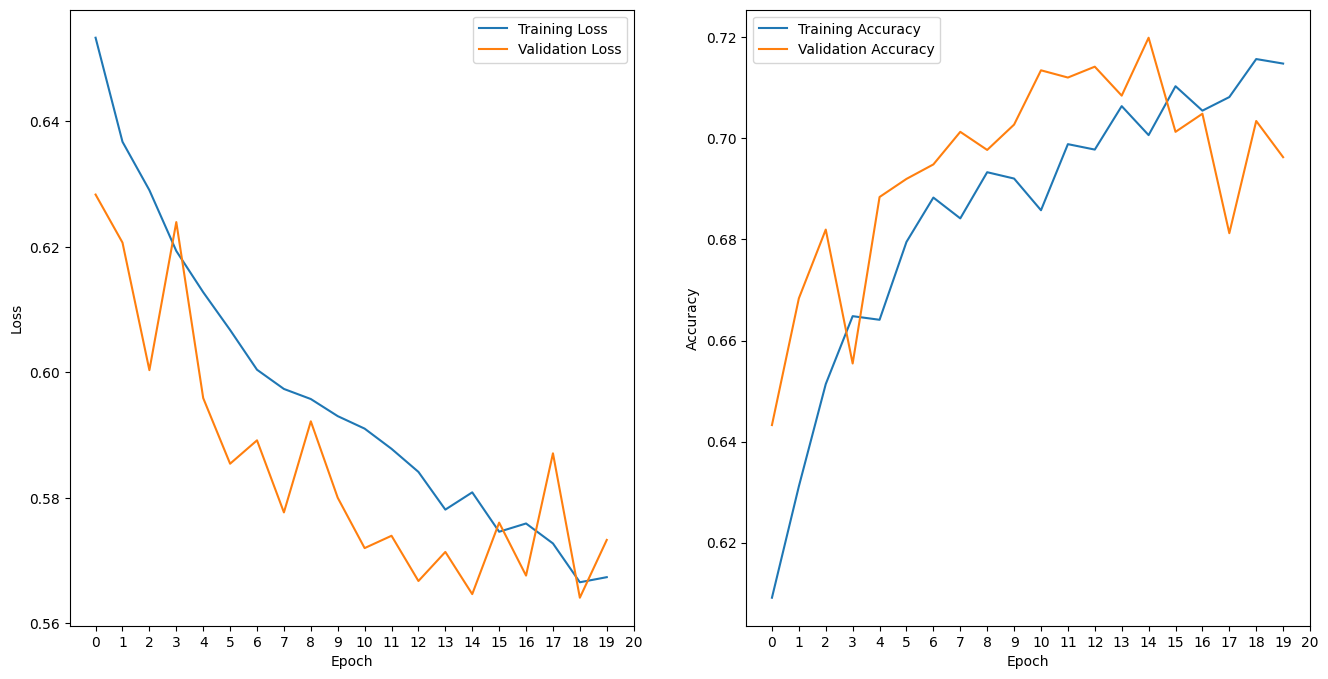

In [118]:
plot_history(res1.history)

In [111]:
submission_df = pd.read_csv(data_dir / 'sample_submission.csv')
test_pred = model1.predict(sequences_test)
submission_df['target'] = (test_pred > 0.5).astype(int)
submission_df.to_csv('submission1.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


In [127]:
best_epoch = np.argmax(res1.history['val_accuracy']) + 1  # Change 0-index to 1-index.
model1_ep_best = load_model(f"models/1/ep{best_epoch:02d}.keras")

In [128]:
submission_df = pd.read_csv(data_dir / 'sample_submission.csv')
test_pred = model1_ep_best.predict(sequences_test)
submission_df['target'] = (test_pred > 0.5).astype(int)
submission_df.to_csv(f"submission1_{best_epoch}.csv", index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


## Results of Model #1

When submitted to Kaggle, the first model (trained to 20 epochs) achieves a score of 0.6923.

Going back to the 15th epoch (the iteration with the highest validation accuracy) achieves a slightly better score of 0.70425.

## Model #2

We'll build the same model but use 128 units in the GRU, instead of the 64 that were previously used.

In [135]:
model2 = gen_model(gru_units=128)
model2.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)             │ ?                           │         748,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_12 (GRU)                         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 748,500 (2.86 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 748,500 (2.86 MB)

In [136]:
checkpoint_callback = get_checkpoint_callback(model_num=2)
res2 = model2.fit(
    x=sequences,
    y=train['target'],
    epochs=20,
    callbacks=[checkpoint_callback],
    validation_split=0.2,
)

Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - F1Score: 0.5836 - accuracy: 0.5960 - loss: 0.6643 - val_F1Score: 0.6047 - val_accuracy: 0.6304 - val_loss: 0.6301
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 100ms/step - F1Score: 0.5685 - accuracy: 0.6354 - loss: 0.6268 - val_F1Score: 0.6047 - val_accuracy: 0.6576 - val_loss: 0.6102
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - F1Score: 0.5672 - accuracy: 0.6578 - loss: 0.6170 - val_F1Score: 0.6047 - val_accuracy: 0.6719 - val_loss: 0.6136
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - F1Score: 0.5765 - accuracy: 0.6711 - loss: 0.6195 - val_F1Score: 0.6047 - val_accuracy: 0.6827 - val_loss: 0.5997
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 102ms/step - F1Score: 0.5752 - accuracy: 0.6737 - loss: 0.6077 - val_F1Score: 0.6047 - val_accuracy: 0.6920 - val_loss: 0.5947
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - F1Score: 0.5822 - accuracy: 0.6695 - loss: 0.6120 - val_F1Score: 0.6047 - val_accuracy: 

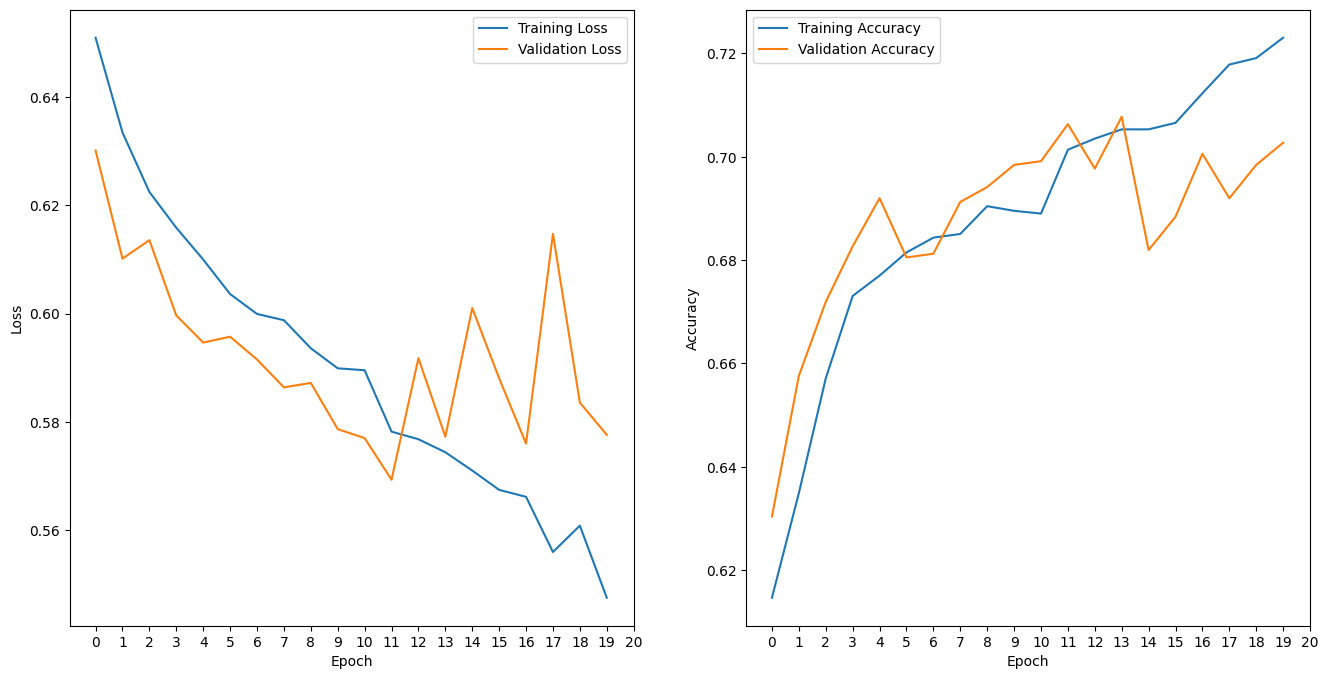

In [137]:
plot_history(res2.history)

In [142]:
best_val_acc = np.argmax(res2.history['val_accuracy']) + 1  # Epoch 14
best_val_loss = np.argmin(res2.history['val_loss']) + 1  # Epoch 12
# Incredibly close validation accuracy, so we'll use the index for the best
# validation loss, since that's also lower.
print("Validation accuracy at epoch", best_val_acc, res2.history['val_accuracy'][best_val_acc - 1])
print("Validation accuracy at epoch", best_val_loss, res2.history['val_accuracy'][best_val_loss - 1])
model2_ep_best = load_model(f"models/2/ep{best_val_loss:02d}.keras")

Validation accuracy at epoch 14 0.7077363729476929
Validation accuracy at epoch 12 0.7063037157058716


In [143]:
submission_df = pd.read_csv(data_dir / 'sample_submission.csv')
test_pred = model2_ep_best.predict(sequences_test)
submission_df['target'] = (test_pred > 0.5).astype(int)
submission_df.to_csv(f"submission2_{best_val_loss}.csv", index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step


## Results of Model #2

When submitted to Kaggle, the second model at the 12th epoch achieves a score of 0.70027, which is comparable to the first model.

## A closer look at the predictions

Because Model #1 had better results, let's use it to take a look at the confusion matrix for its predictions for the training data.

In [147]:
train_pred = model1_ep_best.predict(sequences)
train_pred_bin = (train_pred > 0.5).astype(int)

219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step


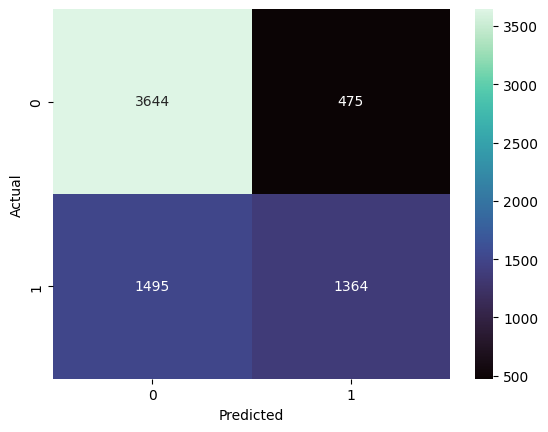

In [149]:
cf_mtx = confusion_matrix(train['target'], train_pred_bin)
sns.heatmap(cf_mtx, cmap='mako', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The model is clearly hesitant to predict `1`. Recall that approximately 43% of the labels in the training data are `1`, but only 26.4% of the predicted labels are `1`.

# Conclusions

The GRU-based architecture used for the model achieved a reasonably good score when submitting to Kaggle, but its hesitence to predict `1` means the architecture and/or preprocessing would need further refinement before putting it to practical use. Adding units to the GRU layer was not sufficient to improve its performance.

# Citations

* https://www.geeksforgeeks.org/how-to-import-kaggle-datasets-directly-into-google-colab/
* https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/
* https://stats.stackexchange.com/a/523076
* https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456
* ChatGPT: referenced in code comments or text cells, as seen above.
* The AI provided in Google Colab helped troubleshoot some errors, especially around plugging the Word2Vec results into the RNN.

In [151]:
import shutil
from pathlib import Path
shutil.make_archive('models', 'zip', 'models')

'/content/models.zip'